## Tabular training

In [1]:
# Install libraries on first run
#! pip install -q ipynb fastai pathlib pandas import_ipynb numpy

In [2]:
from fastai.tabular.all import *
import yfinance as yf
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import import_ipynb
import numpy as np
import random

## Variables

In [3]:
modelName = 'stockScreenerV3.0'
trainingDataName = 'stockData.csv'
trainingFolder = Path.cwd().parent / 'TrainingData'
modelFolder = Path.cwd().parent.parent / 'TrainedModels'
testFolder = Path.cwd().parent / 'TestData'

# Training parameters
yNames = ['Future Year Change']
catNames = ['Industry']
contNames = [
    'Open',
    'High', 
    'Low', 
    'Close', 
    'Volume', 
    'Dividends', 
    'Stock Splits', 
    'EV/EBIT', 
    'ROIC'
]
epochs = 2

# Test parameters
testSize = 100 # Number of stocks to test

Then we can have a look at how the data is structured:

In [4]:
dataPath = Path()
df = pd.read_csv(trainingFolder/trainingDataName)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future Year Change,Ticker,Industry,Adj Close,EV/EBIT,ROIC
0,1996-11-07 00:00:00-05:00,12.482195,12.534641,12.351079,12.482195,93521.0,0.0,0.0,0.302521,NVS,Drug Manufacturers - General,NaN,5.775368,0.136788
1,1996-11-08 00:00:00-05:00,12.508417,12.560863,12.351078,12.508417,26338.0,0.0,0.0,0.274633,NVS,Drug Manufacturers - General,NaN,5.782366,0.136622
2,1996-11-11 00:00:00-05:00,12.665755,12.744425,12.508418,12.665755,22097.0,0.0,0.0,0.274068,NVS,Drug Manufacturers - General,NaN,5.824358,0.135637
3,1996-11-12 00:00:00-05:00,12.560862,12.691977,12.482191,12.560862,78343.0,0.0,0.0,0.286012,NVS,Drug Manufacturers - General,NaN,5.796363,0.136292
4,1996-11-13 00:00:00-05:00,12.534638,12.587085,12.377301,12.534638,27007.0,0.0,0.0,0.255230,NVS,Drug Manufacturers - General,NaN,5.789364,0.136457


Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical (like workclass or education) and we will convert them to a unique index that we will feed to embedding layers. We can specify our categorical and continuous column names, as well as the name of the dependent variable in TabularDataLoaders factory methods:

In [5]:
dls = TabularDataLoaders.from_csv(trainingFolder/trainingDataName, path=dataPath, 
    y_names=yNames,
    cat_names=catNames,
    cont_names=contNames,
    procs = [Categorify, FillMissing, Normalize])

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

The last part is the list of pre-processors we apply to our data:

* Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
* FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
* Normalize will normalize the continuous variables (subtract the mean and divide by the std)

To further expose what’s going on below the surface, let’s rewrite this utilizing fastai’s TabularPandas class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [6]:
splits = EndSplitter (valid_pct=0.2, valid_last=True)(range_of(df))

In [7]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
    y_names=yNames,
    cat_names = catNames,
    cont_names = contNames,
    splits=splits)

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Once we build our TabularPandas object, our data is completely preprocessed as seen below:

In [8]:
to.xs.iloc[:1]

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC
0,14,1,1,-0.213232,-0.21596,-0.214281,-0.21477,-0.506834,-0.047449,-0.014296,-0.097244,-0.095044


Now we can build our DataLoaders again:

In [9]:
dls = to.dataloaders(bs=64)

The show_batch method works like for every other application:

In [10]:
dls.show_batch()

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change
0,Gold,False,False,2.118698,2.281673,1.955719,2.118697,8.339994e+04,2.378207e-11,-1.549504e-11,5.251971,0.150419,0.070769
1,Communication Equipment,False,False,5.487472,5.534897,5.291008,5.419729,9.002200e+06,2.378207e-11,-1.549504e-11,0.345004,2.289823,0.277130
2,Auto Manufacturers,False,False,14.698119,14.727615,14.560480,14.599805,1.336999e+05,2.378207e-11,-1.549504e-11,3.225746,0.244904,0.224242
3,Education & Training Services,False,False,3.529997,3.910001,3.520000,3.680000,1.299120e+07,2.378207e-11,-1.549504e-11,-5.154705,-0.153258,0.921196
4,Banks - Regional,False,False,3.529997,3.549999,3.520000,3.550000,1.416000e+05,2.378207e-11,-1.549504e-11,-103.489479,-0.007633,-0.014084
5,Steel,False,False,103.854968,107.190900,103.732324,106.921073,2.147200e+06,2.378207e-11,-1.549504e-11,9.562223,0.082616,-0.198726
6,Solar,False,False,24.832321,25.912374,24.699529,25.301525,1.060500e+06,2.378207e-11,-1.549504e-11,0.995560,0.793523,-0.685094
7,Drug Manufacturers - General,False,False,67.471870,67.880746,62.872098,67.812599,4.352400e+06,2.378207e-11,-1.549504e-11,20.542476,0.038457,0.114338
8,Medical Devices,False,False,23.374443,23.702153,23.172775,23.601318,2.353700e+06,2.378207e-11,-1.549504e-11,10.513051,0.075145,-0.574894
9,Software - Application,False,False,171.800001,179.949988,171.009993,174.039997,4.625900e+06,2.378207e-11,-1.549504e-11,113.372823,0.006968,-0.146231


We can define a model using the tabular_learner method. When we define our model, fastai will try to infer the loss function based on our y_names earlier.

Note: Sometimes with tabular data, your y’s may be encoded (such as 0 and 1). In such a case you should explicitly pass y_block = CategoryBlock in your constructor so fastai won’t presume you are doing regression.

In [11]:
learn = tabular_learner(dls, metrics=[rmse, mae])

And we can train that model with the fit_one_cycle method (the fine_tune method won’t be useful here since we don’t have a pretrained model).

In [12]:
print(f"Training {modelName} for {epochs} epochs")
learn.fit_one_cycle(epochs)

Training stockScreenerV3.0 for 2 epochs


epoch,train_loss,valid_loss,_rmse,mae,time
0,0.629530,1.071991,1.035370,0.368362,01:25
1,1.278168,2.761754,1.661854,0.375936,01:23


We can then have a look at some training predictions:

In [13]:
learn.show_results(max_n=15)

,Industry,EV/EBIT_na,ROIC_na,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Future Year Change,Future Year Change_pred
0,1.0,1.0,1.0,-0.120210,-0.123409,-0.121906,-0.124042,-0.401535,-0.047449,-0.014296,-0.063018,-0.095218,-0.358323,0.308664
1,33.0,1.0,1.0,-0.095239,-0.097468,-0.098962,-0.099198,-0.463634,-0.047449,-0.014296,2.957398,-0.096435,-0.627244,-0.194502
2,6.0,1.0,1.0,-0.074404,-0.077448,-0.073455,-0.075739,-0.310688,-0.047449,-0.014296,-0.956742,-0.097220,-0.461201,-0.031235
3,13.0,1.0,1.0,-0.241912,-0.244736,-0.243462,-0.244704,-0.359955,-0.047449,-0.014296,-0.150312,-0.094662,-0.536003,0.281974
4,6.0,1.0,1.0,-0.269852,-0.272326,-0.271713,-0.272344,1.227808,-0.047449,-0.014296,-0.253601,-0.092823,0.231829,0.159269
5,4.0,1.0,1.0,-0.104186,-0.105591,-0.102708,-0.104822,-0.469821,-0.047449,-0.014296,-0.277186,-0.091760,-0.353511,0.107557
6,5.0,1.0,1.0,-0.270804,-0.273187,-0.271992,-0.272442,-0.524608,-0.047449,-0.014296,-1.805850,-0.096830,0.412326,0.204904
7,6.0,1.0,1.0,-0.279827,-0.282121,-0.281985,-0.282440,4.919855,-0.047449,-0.014296,0.039233,-0.095561,0.034697,-0.019836
8,6.0,1.0,1.0,-0.201304,-0.203355,-0.201341,-0.202269,-0.013630,-0.047449,-0.014296,-1.263635,-0.096995,-0.245435,-0.074713
9,45.0,1.0,1.0,0.194871,0.194561,0.200385,0.194176,-0.418617,-0.047449,-0.014296,-0.319466,-0.086756,0.519859,-0.030698


## Evaluation

In [14]:
import stockFetcher

$LEJU: possibly delisted; no timezone found
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LEJU?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LEJU&crumb=vSmwn1lwQ8s
<string>:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


$NESN: possibly delisted; no timezone found


Error fetching data for NESN: No historical data available for NESN around 2024-01-22.
Skipping NESN due to missing data


$SPWR: possibly delisted; no timezone found


Error fetching data for SPWR: No historical data available for SPWR around 2024-01-22.
Skipping SPWR due to missing data


$RDS.A: possibly delisted; no timezone found


Error fetching data for RDS.A: No historical data available for RDS.A around 2024-01-22.
Skipping RDS.A due to missing data


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RUN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RUN&crumb=Edge%3A+Too+Many+Requests
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RUN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RUN&crumb=Edge%3A+Too+Many+Requests
Failed to get ticker 'TRV' reason: Expecting value: line 1 column 1 (char 0)
$TRV: possibly delisted; no timezone found


Error fetching data for TRV: No historical data available for TRV around 2024-01-22.
Skipping TRV due to missing data


Failed to get ticker 'KEY' reason: Expecting value: line 1 column 1 (char 0)
$KEY: possibly delisted; no timezone found


Error fetching data for KEY: No historical data available for KEY around 2024-01-22.
Skipping KEY due to missing data


$PYPL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PYPL: No historical data available for PYPL around 2024-01-22.
Skipping PYPL due to missing data


$MO: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MO: No historical data available for MO around 2024-01-22.
Skipping MO due to missing data


Failed to get ticker 'PNC' reason: Expecting value: line 1 column 1 (char 0)
$PNC: possibly delisted; no timezone found


Error fetching data for PNC: No historical data available for PNC around 2024-01-22.
Skipping PNC due to missing data


Failed to get ticker 'PGR' reason: Expecting value: line 1 column 1 (char 0)
$PGR: possibly delisted; no timezone found


Error fetching data for PGR: No historical data available for PGR around 2024-01-22.
Skipping PGR due to missing data


Failed to get ticker 'TRGP' reason: Expecting value: line 1 column 1 (char 0)
$TRGP: possibly delisted; no timezone found


Error fetching data for TRGP: No historical data available for TRGP around 2024-01-22.
Skipping TRGP due to missing data


Failed to get ticker 'HIG' reason: Expecting value: line 1 column 1 (char 0)
$HIG: possibly delisted; no timezone found


Error fetching data for HIG: No historical data available for HIG around 2024-01-22.
Skipping HIG due to missing data


Failed to get ticker 'LC' reason: Expecting value: line 1 column 1 (char 0)
$LC: possibly delisted; no timezone found


Error fetching data for LC: No historical data available for LC around 2024-01-22.
Skipping LC due to missing data


Failed to get ticker 'PSX' reason: Expecting value: line 1 column 1 (char 0)
$PSX: possibly delisted; no timezone found


Error fetching data for PSX: No historical data available for PSX around 2024-01-22.
Skipping PSX due to missing data


Failed to get ticker 'KMI' reason: Expecting value: line 1 column 1 (char 0)
$KMI: possibly delisted; no timezone found


Error fetching data for KMI: No historical data available for KMI around 2024-01-22.
Skipping KMI due to missing data


Failed to get ticker 'ESTC' reason: Expecting value: line 1 column 1 (char 0)
$ESTC: possibly delisted; no timezone found


Error fetching data for ESTC: No historical data available for ESTC around 2024-01-22.
Skipping ESTC due to missing data


Failed to get ticker 'BKR' reason: Expecting value: line 1 column 1 (char 0)
$BKR: possibly delisted; no timezone found


Error fetching data for BKR: No historical data available for BKR around 2024-01-22.
Skipping BKR due to missing data


Failed to get ticker 'SPLK' reason: Expecting value: line 1 column 1 (char 0)
$SPLK: possibly delisted; no timezone found


Error fetching data for SPLK: No historical data available for SPLK around 2024-01-22.
Skipping SPLK due to missing data


Failed to get ticker 'AMTD' reason: Expecting value: line 1 column 1 (char 0)
$AMTD: possibly delisted; no timezone found


Error fetching data for AMTD: No historical data available for AMTD around 2024-01-22.
Skipping AMTD due to missing data


Failed to get ticker 'STT' reason: Expecting value: line 1 column 1 (char 0)
$STT: possibly delisted; no timezone found


Error fetching data for STT: No historical data available for STT around 2024-01-22.
Skipping STT due to missing data


Failed to get ticker 'BTI' reason: Expecting value: line 1 column 1 (char 0)
$BTI: possibly delisted; no timezone found


Error fetching data for BTI: No historical data available for BTI around 2024-01-22.
Skipping BTI due to missing data


Failed to get ticker 'UPST' reason: Expecting value: line 1 column 1 (char 0)
$UPST: possibly delisted; no timezone found


Error fetching data for UPST: No historical data available for UPST around 2024-01-22.
Skipping UPST due to missing data


Failed to get ticker 'AM' reason: Expecting value: line 1 column 1 (char 0)
$AM: possibly delisted; no timezone found


Error fetching data for AM: No historical data available for AM around 2024-01-22.
Skipping AM due to missing data


$DOCU: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DOCU: No historical data available for DOCU around 2024-01-22.
Skipping DOCU due to missing data


Failed to get ticker 'RF' reason: Expecting value: line 1 column 1 (char 0)
$RF: possibly delisted; no timezone found


Error fetching data for RF: No historical data available for RF around 2024-01-22.
Skipping RF due to missing data


Failed to get ticker 'EQIX' reason: Expecting value: line 1 column 1 (char 0)
$EQIX: possibly delisted; no timezone found


Error fetching data for EQIX: No historical data available for EQIX around 2024-01-22.
Skipping EQIX due to missing data


$CVX: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CVX: No historical data available for CVX around 2024-01-22.
Skipping CVX due to missing data


Failed to get ticker 'CYBR' reason: Expecting value: line 1 column 1 (char 0)
$CYBR: possibly delisted; no timezone found


Error fetching data for CYBR: No historical data available for CYBR around 2024-01-22.
Skipping CYBR due to missing data


Failed to get ticker 'ACGL' reason: Expecting value: line 1 column 1 (char 0)
$ACGL: possibly delisted; no timezone found


Error fetching data for ACGL: No historical data available for ACGL around 2024-01-22.
Skipping ACGL due to missing data


Failed to get ticker 'CSGP' reason: Expecting value: line 1 column 1 (char 0)
$CSGP: possibly delisted; no timezone found


Error fetching data for CSGP: No historical data available for CSGP around 2024-01-22.
Skipping CSGP due to missing data


Failed to get ticker 'IMBBY' reason: Expecting value: line 1 column 1 (char 0)
$IMBBY: possibly delisted; no timezone found


Error fetching data for IMBBY: No historical data available for IMBBY around 2024-01-22.
Skipping IMBBY due to missing data


Failed to get ticker 'DFS' reason: Expecting value: line 1 column 1 (char 0)
$DFS: possibly delisted; no timezone found


Error fetching data for DFS: No historical data available for DFS around 2024-01-22.
Skipping DFS due to missing data


Failed to get ticker 'NTRS' reason: Expecting value: line 1 column 1 (char 0)
$NTRS: possibly delisted; no timezone found


Error fetching data for NTRS: No historical data available for NTRS around 2024-01-22.
Skipping NTRS due to missing data


$ENI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ENI: No historical data available for ENI around 2024-01-22.
Skipping ENI due to missing data


$CRWD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CRWD: No historical data available for CRWD around 2024-01-22.
Skipping CRWD due to missing data


Failed to get ticker 'ALL' reason: Expecting value: line 1 column 1 (char 0)
$ALL: possibly delisted; no timezone found


Error fetching data for ALL: No historical data available for ALL around 2024-01-22.
Skipping ALL due to missing data


$DDOG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DDOG: No historical data available for DDOG around 2024-01-22.
Skipping DDOG due to missing data


Failed to get ticker 'ENPH' reason: Expecting value: line 1 column 1 (char 0)
$ENPH: possibly delisted; no timezone found


Error fetching data for ENPH: No historical data available for ENPH around 2024-01-22.
Skipping ENPH due to missing data


Failed to get ticker 'EOG' reason: Expecting value: line 1 column 1 (char 0)
$EOG: possibly delisted; no timezone found


Error fetching data for EOG: No historical data available for EOG around 2024-01-22.
Skipping EOG due to missing data


Failed to get ticker 'CSIQ' reason: Expecting value: line 1 column 1 (char 0)
$CSIQ: possibly delisted; no timezone found


Error fetching data for CSIQ: No historical data available for CSIQ around 2024-01-22.
Skipping CSIQ due to missing data


Failed to get ticker 'VRSK' reason: Expecting value: line 1 column 1 (char 0)
$VRSK: possibly delisted; no timezone found


Error fetching data for VRSK: No historical data available for VRSK around 2024-01-22.
Skipping VRSK due to missing data


Failed to get ticker 'RDFN' reason: Expecting value: line 1 column 1 (char 0)
$RDFN: possibly delisted; no timezone found


Error fetching data for RDFN: No historical data available for RDFN around 2024-01-22.
Skipping RDFN due to missing data


Failed to get ticker 'BAM' reason: Expecting value: line 1 column 1 (char 0)
$BAM: possibly delisted; no timezone found


Error fetching data for BAM: No historical data available for BAM around 2024-01-22.
Skipping BAM due to missing data


Failed to get ticker 'ICE' reason: Expecting value: line 1 column 1 (char 0)
$ICE: possibly delisted; no timezone found


Error fetching data for ICE: No historical data available for ICE around 2024-01-22.
Skipping ICE due to missing data


Failed to get ticker 'PANW' reason: Expecting value: line 1 column 1 (char 0)
$PANW: possibly delisted; no timezone found


Error fetching data for PANW: No historical data available for PANW around 2024-01-22.
Skipping PANW due to missing data


Failed to get ticker 'LMND' reason: Expecting value: line 1 column 1 (char 0)
$LMND: possibly delisted; no timezone found


Error fetching data for LMND: No historical data available for LMND around 2024-01-22.
Skipping LMND due to missing data


Failed to get ticker 'SCHW' reason: Expecting value: line 1 column 1 (char 0)
$SCHW: possibly delisted; no timezone found


Error fetching data for SCHW: No historical data available for SCHW around 2024-01-22.
Skipping SCHW due to missing data


Failed to get ticker 'ET' reason: Expecting value: line 1 column 1 (char 0)
$ET: possibly delisted; no timezone found


Error fetching data for ET: No historical data available for ET around 2024-01-22.
Skipping ET due to missing data


Failed to get ticker 'SEDG' reason: Expecting value: line 1 column 1 (char 0)
$SEDG: possibly delisted; no timezone found


Error fetching data for SEDG: No historical data available for SEDG around 2024-01-22.
Skipping SEDG due to missing data


Failed to get ticker 'MKC' reason: Expecting value: line 1 column 1 (char 0)
$MKC: possibly delisted; no timezone found


Error fetching data for MKC: No historical data available for MKC around 2024-01-22.
Skipping MKC due to missing data


Failed to get ticker 'DANOY' reason: Expecting value: line 1 column 1 (char 0)
$DANOY: possibly delisted; no timezone found


Error fetching data for DANOY: No historical data available for DANOY around 2024-01-22.
Skipping DANOY due to missing data


Failed to get ticker 'RNR' reason: Expecting value: line 1 column 1 (char 0)
$RNR: possibly delisted; no timezone found


Error fetching data for RNR: No historical data available for RNR around 2024-01-22.
Skipping RNR due to missing data


Failed to get ticker 'WMB' reason: Expecting value: line 1 column 1 (char 0)
$WMB: possibly delisted; no timezone found


Error fetching data for WMB: No historical data available for WMB around 2024-01-22.
Skipping WMB due to missing data


Failed to get ticker 'VLO' reason: Expecting value: line 1 column 1 (char 0)
$VLO: possibly delisted; no timezone found


Error fetching data for VLO: No historical data available for VLO around 2024-01-22.
Skipping VLO due to missing data


$AFRM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for AFRM: No historical data available for AFRM around 2024-01-22.
Skipping AFRM due to missing data


Failed to get ticker 'BK' reason: Expecting value: line 1 column 1 (char 0)
$BK: possibly delisted; no timezone found


Error fetching data for BK: No historical data available for BK around 2024-01-22.
Skipping BK due to missing data


Failed to get ticker 'ROOT' reason: Expecting value: line 1 column 1 (char 0)
$ROOT: possibly delisted; no timezone found


Error fetching data for ROOT: No historical data available for ROOT around 2024-01-22.
Skipping ROOT due to missing data


Failed to get ticker 'COF' reason: Expecting value: line 1 column 1 (char 0)
$COF: possibly delisted; no timezone found


Error fetching data for COF: No historical data available for COF around 2024-01-22.
Skipping COF due to missing data


$L: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for L: No historical data available for L around 2024-01-22.
Skipping L due to missing data


Failed to get ticker 'DLR' reason: Expecting value: line 1 column 1 (char 0)
$DLR: possibly delisted; no timezone found


Error fetching data for DLR: No historical data available for DLR around 2024-01-22.
Skipping DLR due to missing data


Failed to get ticker 'AMT' reason: Expecting value: line 1 column 1 (char 0)
$AMT: possibly delisted; no timezone found


Error fetching data for AMT: No historical data available for AMT around 2024-01-22.
Skipping AMT due to missing data


Failed to get ticker 'SOFI' reason: Expecting value: line 1 column 1 (char 0)
$SOFI: possibly delisted; no timezone found


Error fetching data for SOFI: No historical data available for SOFI around 2024-01-22.
Skipping SOFI due to missing data


Failed to get ticker 'BLDP' reason: Expecting value: line 1 column 1 (char 0)
$BLDP: possibly delisted; no timezone found


Error fetching data for BLDP: No historical data available for BLDP around 2024-01-22.
Skipping BLDP due to missing data


Failed to get ticker 'MPC' reason: Expecting value: line 1 column 1 (char 0)
$MPC: possibly delisted; no timezone found


Error fetching data for MPC: No historical data available for MPC around 2024-01-22.
Skipping MPC due to missing data


Failed to get ticker 'CME' reason: Expecting value: line 1 column 1 (char 0)
$CME: possibly delisted; no timezone found


Error fetching data for CME: No historical data available for CME around 2024-01-22.
Skipping CME due to missing data


Failed to get ticker 'HAL' reason: Expecting value: line 1 column 1 (char 0)
$HAL: possibly delisted; no timezone found


Error fetching data for HAL: No historical data available for HAL around 2024-01-22.
Skipping HAL due to missing data


Failed to get ticker 'TFC' reason: Expecting value: line 1 column 1 (char 0)
$TFC: possibly delisted; no timezone found


Error fetching data for TFC: No historical data available for TFC around 2024-01-22.
Skipping TFC due to missing data


$OKTA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for OKTA: No historical data available for OKTA around 2024-01-22.
Skipping OKTA due to missing data


Failed to get ticker 'IBKR' reason: Expecting value: line 1 column 1 (char 0)
$IBKR: possibly delisted; no timezone found


Error fetching data for IBKR: No historical data available for IBKR around 2024-01-22.
Skipping IBKR due to missing data


Failed to get ticker 'PM' reason: Expecting value: line 1 column 1 (char 0)
$PM: possibly delisted; no timezone found


Error fetching data for PM: No historical data available for PM around 2024-01-22.
Skipping PM due to missing data


Failed to get ticker 'CHKP' reason: Expecting value: line 1 column 1 (char 0)
$CHKP: possibly delisted; no timezone found


Error fetching data for CHKP: No historical data available for CHKP around 2024-01-22.
Skipping CHKP due to missing data


Failed to get ticker 'EXPI' reason: Expecting value: line 1 column 1 (char 0)
$EXPI: possibly delisted; no timezone found


Error fetching data for EXPI: No historical data available for EXPI around 2024-01-22.
Skipping EXPI due to missing data


$FSLY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FSLY: No historical data available for FSLY around 2024-01-22.
Skipping FSLY due to missing data


Failed to get ticker 'RLI' reason: Expecting value: line 1 column 1 (char 0)
$RLI: possibly delisted; no timezone found


Error fetching data for RLI: No historical data available for RLI around 2024-01-22.
Skipping RLI due to missing data


Failed to get ticker 'MKL' reason: Expecting value: line 1 column 1 (char 0)
$MKL: possibly delisted; no timezone found


Error fetching data for MKL: No historical data available for MKL around 2024-01-22.
Skipping MKL due to missing data


C:\Users\Gamer\AppData\Local\Temp\ipykernel_18860\1918869076.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_test_data = pd.concat(test_data_list, ignore_index=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origi

Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\modelEvaluations.csv


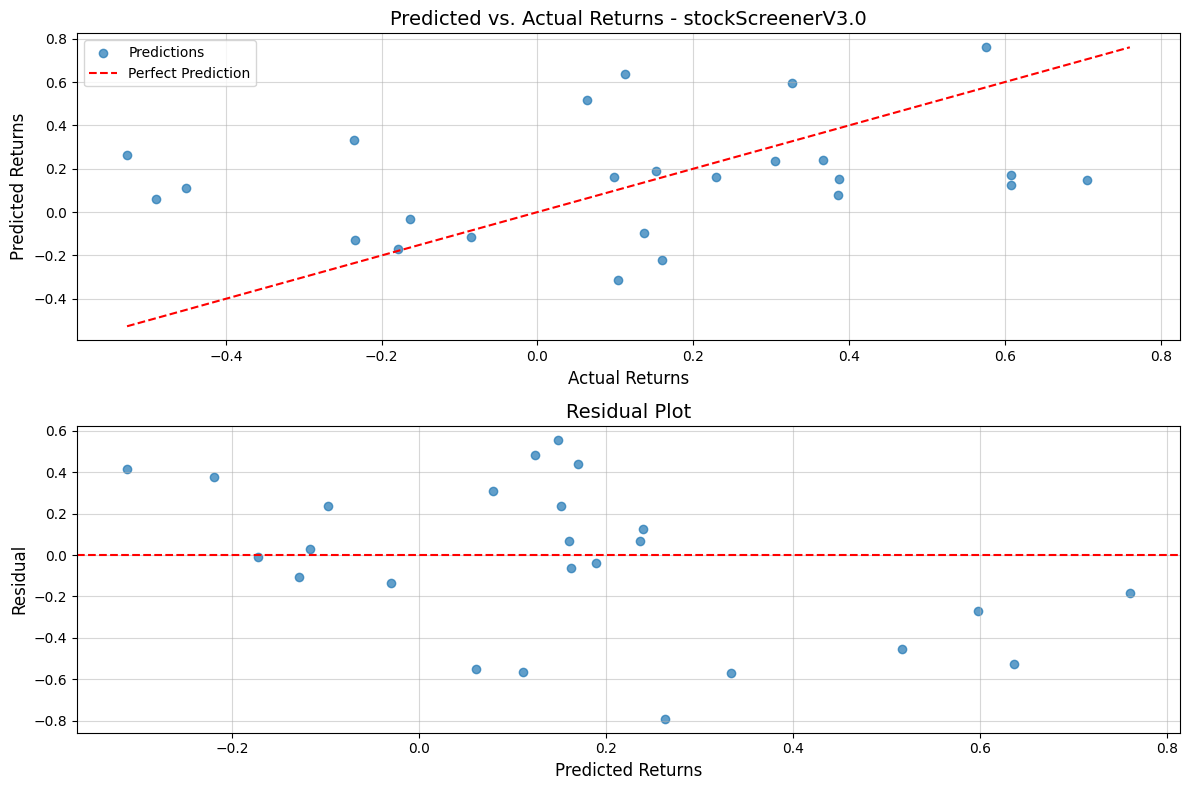

Evaluation Results:
MAE: 0.304
RMSE: 0.373
R2: -0.195


In [15]:
def evaluate_model(learn, test_tickers, model_name, model_folder, cont_names, cat_names):
    """
    Evaluate a fastai model on a list of test tickers and log the results.
    
    Args:
        learn: fastai Learner object
        test_tickers (list): List of ticker symbols to test on
        model_name (str): Name of the model for logging
        model_folder (Path): Path to save evaluation results
        cont_names (list): List of continuous feature names
        cat_names (list): List of categorical feature names
    """
    all_predictions = []
    all_actuals = []
    test_data_list = []
    
    # Collect test data for all tickers
    for ticker in test_tickers:
        try:
            # Get test data
            test_data = stockFetcher.getTickerDataFrom1YrAgo(ticker)
            if test_data.empty:
                print(f"Skipping {ticker} due to missing data")
                continue
            
            test_data_list.append(test_data)
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            continue
    
    if not test_data_list:
        print("No valid test data collected")
        return None, None, None
    
    # Combine all test data
    combined_test_data = pd.concat(test_data_list, ignore_index=True)
    
    # Create fastai test dataloader
    test_dl = learn.dls.test_dl(combined_test_data)
    
    # Get predictions
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Convert to numpy arrays
    predictions = preds.numpy()
    actuals = targs.numpy()
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame({
        'Predicted': predictions.flatten(),
        'Actual': actuals.flatten()
    })

    # Calculate residuals
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Define outlier threshold (2 standard deviations)
    outlier_threshold = 2 * results_df['Residual'].std()

    # Filter outliers
    filtered_df = results_df[abs(results_df['Residual']) <= outlier_threshold]

    # Calculate metrics
    mae = np.mean(np.abs(filtered_df['Residual']))
    rmse = np.sqrt(np.mean(filtered_df['Residual']**2))
    r2 = 1 - (np.sum(filtered_df['Residual']**2) / 
              np.sum((filtered_df['Actual'] - filtered_df['Actual'].mean())**2))

    # Log results
    log_evaluation(model_name, mae, rmse, r2, model_folder)
    
    # Create visualizations
    plot_results(filtered_df, model_name, model_folder)
    
    return mae, rmse, r2

def log_evaluation(model_name, mae, rmse, r2, model_folder):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": modelName,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Test Amount": len(get_random_test_tickers(n_tickers=testSize)),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plot_results(filtered_df, model_name, model_folder):
    """Create and save visualization plots"""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.subplot(2, 1, 1)
    actuals = filtered_df['Actual']
    predictions = filtered_df['Predicted']
    plt.scatter(actuals, predictions, alpha=0.7, label='Predictions')
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', label='Perfect Prediction')
    
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns', fontsize=12)
    plt.ylabel('Predicted Returns', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    
    # Residual plot
    plt.subplot(2, 1, 2)
    plt.scatter(predictions, filtered_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    
    # Show plot
    plt.show()

# Function to get random test tickers
def get_random_test_tickers(n_tickers):
    """
    Get random US-listed tickers that aren't in our training set.
    
    Args:
        n_tickers (int): Number of test tickers to return
        
    Returns:
        list: List of ticker symbols
    """
    training_tickers = set(stockFetcher.symbols)
    
    # Get US exchange tickers using pandas_datareader
    try:
        # Get ADR tickers
        adr_df = pd.read_csv(testFolder / 'tickers.csv')
        tickers = adr_df['Ticker'].tolist()
        
        # Clean tickers (remove warrants, preferred shares, etc.)
        clean_tickers = [
            ticker for ticker in tickers 
            if ticker not in training_tickers
        ]
        
        # Randomly select tickers
        if len(clean_tickers) < n_tickers:
            print(f"Warning: Only {len(clean_tickers)} tickers available")
            return clean_tickers
            
        return np.random.choice(clean_tickers, size=n_tickers, replace=False).tolist()
        
    except Exception as e:
        print(f"Error fetching tickers: {e}")
        # Fallback to a list of common US tickers not in training set
        fallback_tickers = [
            'KO', 'PEP', 'JNJ', 'PG', 'WMT', 'HD', 'MCD', 'NKE', 
            'DIS', 'SBUX', 'COST', 'TGT', 'LOW', 'MO', 'CVS'
        ]
        fallback_tickers = [t for t in fallback_tickers if t not in training_tickers]
        return np.random.choice(fallback_tickers, size=min(n_tickers, len(fallback_tickers)), replace=False).tolist()
    
if __name__ == "__main__":
    
    # Evaluate model (replace learn with your actual learner)
    mae, rmse, r2 = evaluate_model(
        learn=learn,  # Your fastai learner
        test_tickers = get_random_test_tickers(n_tickers=testSize),
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )
    
    if mae is not None and rmse is not None and r2 is not None:
        print(f"Evaluation Results:")
        print(f"MAE: {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R2: {r2:.3f}")
    else:
        print("Evaluation failed. Metrics are None.")


## Export the model

In [16]:
learn.export(modelFolder / f'{modelName}.pkl')

## Tests (recommended to use the app instead, but feel free to use the tests below)


To get prediction on a new dataframe, you can use the test_dl method of the DataLoaders. That dataframe does not need to have the dependent variable in its column.

In [18]:
predictionTarget = 'AAPL'

test_df = stockFetcher.getTickerData(predictionTarget)

# Ensure test_df is a DataFrame
if isinstance(test_df, dict):
	test_df = pd.DataFrame([test_df])

# Ensure test_df contains the required columns
required_columns = contNames + catNames
for col in required_columns:
	if col not in test_df.columns:
		test_df[col] = np.nan

dl = learn.dls.test_dl(test_df)
test_df.head()

Error fetching EV components for AAPL: Expecting value: line 1 column 1 (char 0)
Error calculating EBIT for AAPL: Expecting value: line 1 column 1 (char 0)
Error fetching data for AAPL: unsupported operand type(s) for *: 'float' and 'NoneType'


c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,Open,High,Low,Close,Volume,Dividends,Stock Splits,EV/EBIT,ROIC,Industry,EV/EBIT_na,ROIC_na


In [19]:
prediction = learn.get_preds(dl=dl)
print(f"Prediction for {predictionTarget}:")
print(f"{prediction[0][0][0].item() * 100:.2f}%")

c:\Users\Gamer\miniconda3\Lib\site-packages\fastprogress\fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Prediction for AAPL:


TypeError: 'NoneType' object is not subscriptable

Note:
Since machine learning models can’t magically understand categories it was never trained on, the data should reflect this. If there are different missing values in your test data you should address this before training